In [1]:
#%matplotlib notebook
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
print_context_dict ={'text.usetex':True,
                     'text.latex.preamble':"\\usepackage{siunitx}\n \\usepackage{xfrac}",
                     'font.size':10,
                     'legend.fontsize':10,
                     'xtick.labelsize':10,
                     'ytick.labelsize':10,
                     'axes.labelsize':10,
                     'font.family':'serif',
                     'legend.labelspacing':0.1,
                     'axes.linewidth':0.5,
                     'xtick.major.width':0.2,
                     'ytick.major.width':0.2,
                     'xtick.major.width':0.5,
                     'ytick.major.width':0.5,
                     'figure.figsize':(5.906,5.906/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.906/2,5.906/2/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.53/2,2.96),#beamer
                     #'figure.figsize':(5.53/2*2,2.96*2),#beamer
                     'figure.dpi':100}
    #figsize=(5.53,2.96)#beamer 16:9
    #figsize=(3.69,2.96)#beamer 16:9
    #plot.rc('axes.formatter',use_locale=True) #german months
# must be manually set due to some matplotlib bugs
if print_context_dict['text.usetex']:
    #plt.rc('text.latex',unicode=True)
    plt.rc('text',usetex=True)
    plt.rc('text.latex',preamble="\\usepackage{siunitx}\n \\usepackage{xfrac}")


from sympy import *
import sympy.plotting.experimental_lambdify
init_printing()

ModuleNotFoundError: No module named 'sympy'

In [2]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\sfrac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\sfrac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\sfrac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

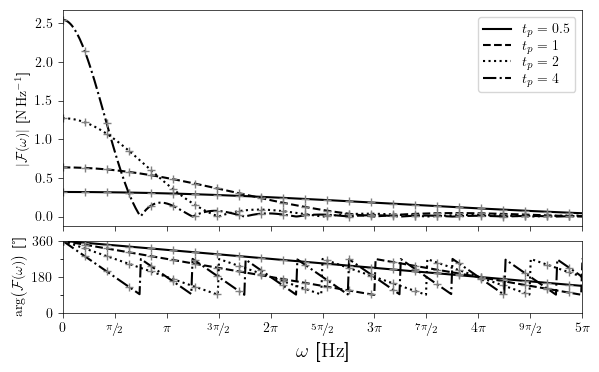

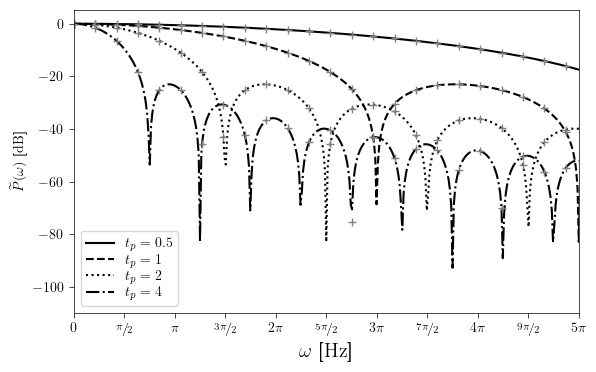

In [3]:
omega = np.linspace(0,20,500)
with matplotlib.rc_context(rc=print_context_dict):
    fig1,[ax,ax2]=plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, sharex=True)
    fig2,ax3=plt.subplots(1,1)

    t= np.linspace(0,3*np.pi,512)
    for ls_,tp in [('solid',.5), ('dashed',1), ('dotted',2), ('dashdot',4)]:
        pulse=np.sin(np.pi/tp*t)
        pulse[t>tp]=0
        fft=np.fft.rfft(pulse)
        deltat=t[1]-t[0]
        fft*=deltat
        fftfreq=np.fft.rfftfreq(pulse.shape[0],deltat)
        fftomega=fftfreq*2*np.pi
        psdn=fft*np.conj(fft)
        F=2*np.pi/tp*np.cos(tp*omega/2)/(np.pi**2/tp**2-omega**2)*np.exp(-1j*tp*omega/2)
        mag=np.abs(F)
        phase=np.angle(F)
        phase[phase<=0]+=2*np.pi
        psd=(2*np.pi/tp*np.cos(tp*omega/2)/(np.pi**2/tp**2-omega**2))**2/((2*np.pi/tp/(np.pi**2/tp**2)))**2
        psd=10*np.log10(psd)
        psdn=np.abs(fft)**2
        psdn /=psdn[0]
        psdn=10*np.log10(psdn)
        
        phasen=np.angle(fft)
        phasen[phasen<=0]+=2*np.pi
        ax.plot(omega, mag, ls=ls_, color='black', label=f'$t_p={tp}$')
        ax.plot(fftomega, np.abs(fft), marker='+', color='grey',ls='none')
        ax2.plot(omega, phase/np.pi*180, color='black',ls=ls_, label=f'$t_p={tp}$')
        ax2.plot(fftomega, phasen/np.pi*180, marker='+', color='grey',ls='none')
#         for i in range(10):
#             inds = np.logical_and(omega>i*2*np.pi/tp, omega<(i+1)*2*np.pi/tp)
#             if inds.any():
#                 print(tp,i)
#                 ax2.plot(omega[inds], phase[inds]/np.pi*180, ls=ls_, color='black',)
        ax3.plot(omega, psd, ls=ls_, color='black', label=f'$t_p={tp}$')
        #ax4.psd(pulse, Fs=1/(t[1]-t[0]),window=matplotlib.mlab.window_none,sides="onesided", label=f'$t_p={tp}$', NFFT=1024)
        ax3.plot(fftomega, psdn, marker='+', color='grey',ls='none')

    ax.set_xlim((0,5*np.pi))
    ax3.set_xlim((0,5*np.pi))
    ax2.set_ylim((0,360))

    #ax4.set_xlim((0,10/2/np.pi))
    #ax4.set_xlim((0,20))
    ax.legend()
    ax3.legend()
    
    
    ax2.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax.set_ylabel('$|\\mathcal{F}(\\omega)|$  [\\si{\\newton\\per\\hertz}]')
    ax2.set_ylabel('$\\arg\\bigl(\mathcal{F}(\omega)\\bigr)$ [\si{\degree}]')

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(180))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(90))
    ax3.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax3.set_ylabel('$\\widetilde{P}(\omega)$  [\si{\decibel}]')
    
    ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax3.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    
fig1.subplots_adjust(top=0.970, bottom=0.140, left=0.095, right=0.975, hspace=0.1)
#fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/fourier_transform_half_sine.pdf')
#fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/fourier_transform_half_sine.png')

fig2.subplots_adjust(top=0.970, bottom=0.140, left=0.120, right=0.975)

plt.show()

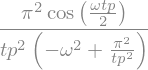

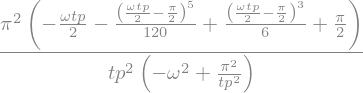

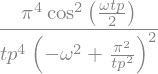

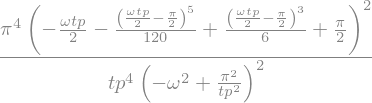

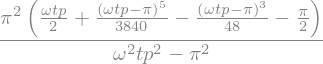

In [4]:
tp,omega = symbols('tp omega', real=True, positive=True)
f=-2*pi/tp*sin(tp*omega/2-pi/2)/(pi**2/tp**2-omega**2)
f0=f.subs(omega,0)
f=f/f0
P=f**2
Pdb=10*log(P,10)
#fexp=2*pi/tp*(1-(omega*tp/2)**2/2+(omega*tp/2)**4/24-(omega*tp/2)**6/720+(omega*tp/2)**8/40320-(omega*tp/2)**10/3628800)/(pi**2/tp**2-omega**2)
fexp=2*pi/tp*(-(omega*tp/2-pi/2) + (omega*tp/2-pi/2)**3/6 -(omega*tp/2-pi/2)**5/120)/(pi**2/tp**2-omega**2)
#fexp=2*pi/tp*(-(omega*tp/2-pi/2) + (omega*tp/2-pi/2)**3/6 )/(pi**2/tp**2-omega**2)
fexp=fexp/f0
Pexp=fexp**2
Pexpdb=10*log(Pexp,10)
#fexp=(pi**2*(1-(omega*tp/2)**2/2+(omega*tp/2)**4/24-(omega*tp/2)**6/720)/(tp**2*(pi**2/tp**2-omega**2)))**2
#fexp=(pi**2*(1-(omega*tp/2)**2/2+(omega*tp/2)**4/24)/(tp**2*(pi**2/tp**2-omega**2)))**2
#fexpdb=10*log(fexp)
display(f)
display(fexp)
display(P)
display(Pexp)
display(simplify(fexp))

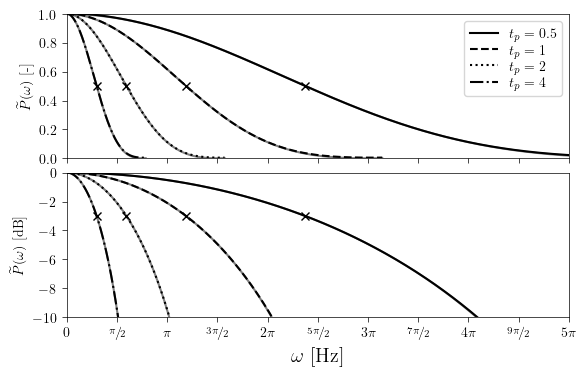

In [5]:
tps=np.linspace(0,10,101)[1:]
om3db=[]
omfact=[]

with matplotlib.rc_context(rc=print_context_dict):
    
    fig1,[ax1,ax2]=plt.subplots(2,1,sharex=True)
    for ls_,tp_ in [('solid',.5), ('dashed',1), ('dotted',2), ('dashdot',4)]:
        om3db.append(re(nsolve(Pdb.subs(tp,tp_)+3,3.72674844020097/tp_)))
        omfact.append(om3db[-1]*tp_)
        #omegas=np.linspace(1.1*np.pi/tp_,2*np.pi/tp_)
        if tp_ in [0.5,1,2,4]:
            omegas=np.linspace(0,np.pi**2/tp_,500)
            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],P.subs(tp,tp_))
            ax1.plot(omegas, exp(omegas), color='black',alpha=.5)
            ax1.plot([3.7291620893186/tp_],exp([3.7291620893186/tp_]), marker='x', color='black')

            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],Pexp.subs(tp,tp_))
            ax1.plot(omegas, exp(omegas), color='black', ls=ls_,label=f'$t_p={tp_}$')

            
            #print(exp([om3db[-1]]),exp([3.7291620893186/tp_]))

            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],Pdb.subs(tp,tp_))
            ax2.plot(omegas, exp(omegas),color='black',alpha=.5)
            ax2.plot([3.7291620893186/tp_],exp([3.7291620893186/tp_]), marker='x', color='black')

            exp=sympy.plotting.experimental_lambdify.vectorized_lambdify([omega],Pexpdb.subs(tp,tp_))
            ax2.plot(omegas, exp(omegas), color='black', ls=ls_)

            
            #print(Pdb.subs(tp,tp_).subs(omega,om3db[-1]).evalf(),Pdb.subs(tp,tp_).subs(omega, 3.7291620893186/tp_).evalf())

    ax1.set_ylim((0,1))
    ax2.set_ylim((-10,0))
    #ax1.set_xlim((0,5*np.pi))
    ax2.set_xlim((0,5*np.pi))
    ax1.legend()
    #ax2.legend()
    
    
    #ax1.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax1.set_ylabel('$\\widetilde{P}(\omega)$  [-]')
    

    ax2.set_xlabel('\Large $\\omega$ [\\si{\\hertz}]')
    ax2.set_ylabel('$\\widetilde{P}(\omega)$  [\si{\decibel}]')
    
    ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    #ax1.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    #ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    
    fig1.subplots_adjust(top=0.970, bottom=0.140, left=0.125, right=0.975, hspace=0.1)
#     fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine_3db.pdf')
#     fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine_3db.png')

    plt.show()


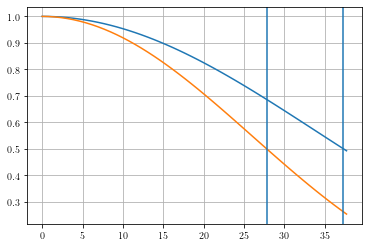

In [6]:
# PSDs of half sine and rectangular

import numpy as np
import matplotlib.pyplot as plt
x=np.linspace(0,12*np.pi)
tp=0.1
y1=(np.pi**2/(np.pi**2-tp**2*x**2)*np.cos(x*tp/2))**2
y2=np.sinc(x/np.pi*tp/2)**2
plt.figure()
plt.plot(x,y1)
plt.plot(x,y2)
plt.axvline(3.72916/tp)
plt.axvline(2.78311/tp)
plt.grid(1)
#plt.ylim([0.6,0.8])
plt.show()

In [7]:
#a=symbols('a')
#omfacts_anal=solve(Eq(simplify(fexp),10**-(3/20)).subs((omega*tp), a))
#display(omfacts_anal)
#fexp.subs(omega, sqrt(omfacts_anal[1])/tp).subs(tp,1)

In [8]:
from sympy import *
f=tp*sinc(tp*omega/2)*exp(-1j*omega)
f/=f.subs(omega,0)
P=abs(f)

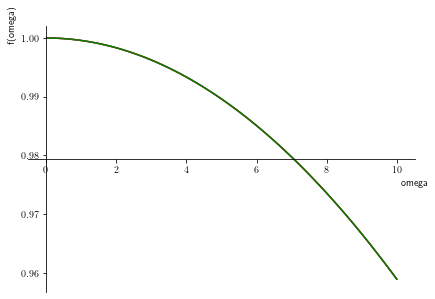

In [9]:
p1=plot(P.subs(tp,1),(omega,0,10), show=False)
p1.append(plot(abs(sinc(omega*tp/2)).subs(tp,0.5),(omega,0,10),line_color='red',show=False)[0])
p1.append(plot(abs((sin(omega*tp/2)/(omega*tp/2))).subs(tp,2), (omega,0,10), line_color='green',show=False)[0])
p1.show()

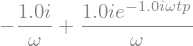

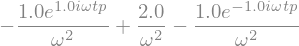

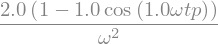

In [10]:
a,t,tp,omega=symbols('a t tp omega', real=True, positive=True)
Pomega=integrate(a*exp(-1j*omega*t),(t,0,tp)).subs(a,1)
display(Pomega)

mag=simplify(abs(Pomega))
display(abs(Pomega)**2)
display(mag**2)

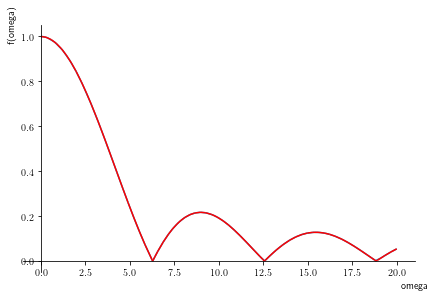

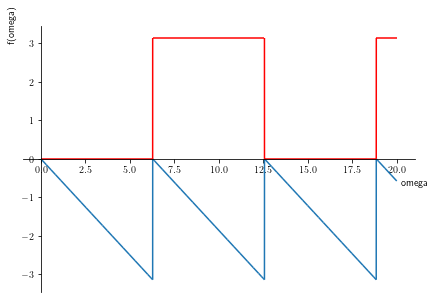

In [11]:
p1=plot(mag.subs(a,1).subs(tp,1),(omega,0,20), show=False)
p1.append(plot(abs((a*tp*sinc(omega*tp/2)).subs(a,1).subs(tp,1)),(omega,0,20),show=False,line_color='red')[0])
p1.show()
p2=plot(arg(Pomega).subs(a,1).subs(tp,1),(omega,0,20), show=False)
p2.append(plot(arg((a*tp*sinc(omega*tp/2)).subs(a,1).subs(tp,1)),(omega,0,20),show=False,line_color='red')[0])
p2.show()

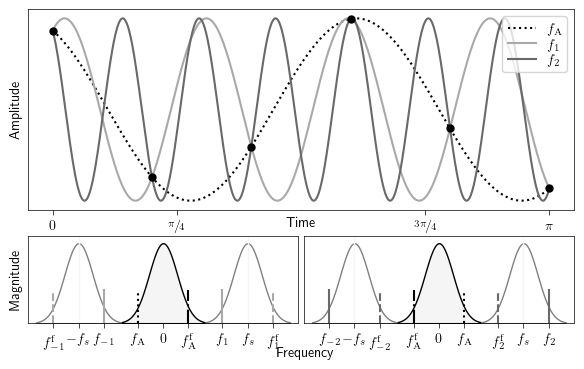

In [12]:
fs=10/(2*np.pi)
dur=np.pi
fa=0.3*fs
phia=2/3*np.pi
ca='black'
f1=0.7*fs
phi1=np.pi-phia
c1='darkgrey'
f2=1.3*fs
phi2=phia
c2='dimgray'
fit = lambda to,f,phi: np.sin(f*2*np.pi*to+phi)
#f2=0.55*fs
t=np.linspace(0,dur,1000,endpoint=True)
with matplotlib.rc_context(rc=print_context_dict):
    
    fig = plt.figure(constrained_layout=False, figsize=(5.906,5.906/1.618))
    gs1 = matplotlib.gridspec.GridSpec(nrows=3, ncols=2)
    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1], sharey=ax2)
    
    ax1.plot(t,fit(t,fa,phia),color=ca, ls='dotted', label='$f_\mathrm{A}$')
    ax1.plot(t,fit(t,f1,phi1), color=c1, ls='solid', label='$f_1$')
    ax1.plot(t,fit(t,f2,phi2), color=c2, ls='solid', label='$f_2$')
    t_=np.linspace(0,dur,int(dur*fs*1+1), endpoint=True)

    ax1.plot(t_,fit(t_,f2,phi2),ls='none',marker='.', markersize=10, color='black')
    ax1.xaxis.set_major_locator(plt.MultipleLocator(0.25*np.pi))
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(4)))
    ax1.set_yticks([])
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Time', backgroundcolor="white",labelpad=-12)
    ax1.legend(loc="upper right")
    # import scipy.optimize
    # popt,_=scipy.optimize.curve_fit(fit, t_, np.sin(f1*2*np.pi*t_), [f2,0])

    
#     f=np.linspace(-2.5*fs,2.5*fs,1000)    
    #fig, axes=plt.subplots(1,2, sharey=True, figsize=(5.906/2,5.906/1.618))
    axes=[ax2,ax3]
    import scipy.stats as stats
    mu=0
    variance = 1
    sigma = np.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

    for ax in axes:
        ax.fill_between(np.linspace(-fs/2,+fs/2,100), stats.norm.pdf(x, mu, sigma)*6, facecolor="whitesmoke", edgecolor="black")
        ax.fill_between(np.linspace(fs-fs/2,fs+fs/2,100), stats.norm.pdf(x, mu, sigma)*6, facecolor="white", edgecolor="grey")
        ax.fill_between(np.linspace(-fs-fs/2,-fs+fs/2,100), stats.norm.pdf(x, mu, sigma)*6, facecolor="white", edgecolor="grey")
       
    axes[0].plot([f1,f1],[0,1], color=c1, ls='solid')
    axes[0].plot([2*fs-f1,2*fs-f1],[0,1], color=c1, ls='dashed')
        
    axes[0].plot([-f1,-f1],[0,1], color=c1, ls='solid')
    axes[0].plot([-2*fs+f1,-2*fs+f1],[0,1], color=c1, ls='dashed')
    
    axes[0].plot([-fa,-fa],[0,1], color=ca, ls='dotted')
    axes[0].plot([fa,fa],[0,1], color=ca, ls='dashdot')
    
    axes[0].axvline(fs, color='whitesmoke', lw=1)
    axes[0].axvline(-fs, color='whitesmoke', lw=1)
    
    xticks=[-2*fs+f1              ,-fs     ,-f1       ,-fa               ,0 ,fa                             ,f1     ,fs     ,2*fs-f1]
    xlabels=['$f_{-1}^\mathrm{f}$','$-f_s$','$f_{-1}$','$f_{\mathrm{A}}$','$0$','$f_{\mathrm{A}}^\mathrm{f}$','$f_1$','$f_s$','$f_1^\mathrm{f}$']
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xlabels)
    
    
    axes[1].plot([f2,f2],[0,1], color=c2, ls='solid')
    axes[1].plot([2*fs-f2,2*fs-f2],[0,1], color=c2, ls='dashed')
        
    axes[1].plot([-f2,-f2],[0,1], color=c2, ls='solid')
    axes[1].plot([-2*fs+f2,-2*fs+f2],[0,1], color=c2, ls='dashed')
    
    axes[1].plot([fa,fa],[0,1], color=ca, ls='dotted')
    axes[1].plot([-fa,-fa],[0,1], color=ca, ls='dashdot')
    
    axes[1].axvline(fs, color='whitesmoke', lw=1)
    axes[1].axvline(-fs, color='whitesmoke', lw=1)
    
    xticks=[-2*fs+f2              ,-fs     ,-f2       ,fa               ,0 ,-fa                             ,f2     ,fs     ,2*fs-f2]
    xlabels=['$f_{-2}^\mathrm{f}$','$-f_s$','$f_{-2}$','$f_{\mathrm{A}}$','$0$','$f_{\mathrm{A}}^\mathrm{f}$','$f_2$','$f_s$','$f_2^\mathrm{f}$']
    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels(xlabels)
    axes[0].set_xlabel('Frequency')
    axes[0].xaxis.set_label_coords(1.03, -0.27)
    #axes[0].set_xlabel('Frequency')
    
    for ax in axes:
        ax.set_ylim((0,2.61))
        ax.set_xlim((-1.6*fs,1.6*fs))
        ax.set_yticks([])
    axes[0].set_ylabel('Magnitude')
    fig.subplots_adjust(top=0.970,bottom=0.11,left=0.045, right=0.97,wspace=0.02,hspace=0.3)
    #http://dspfirst.gatech.edu/chapters/04samplin/demos/aliasing/index.html
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/aliasing_folding.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/aliasing_folding.png')
    

<IPython.core.display.Javascript object>


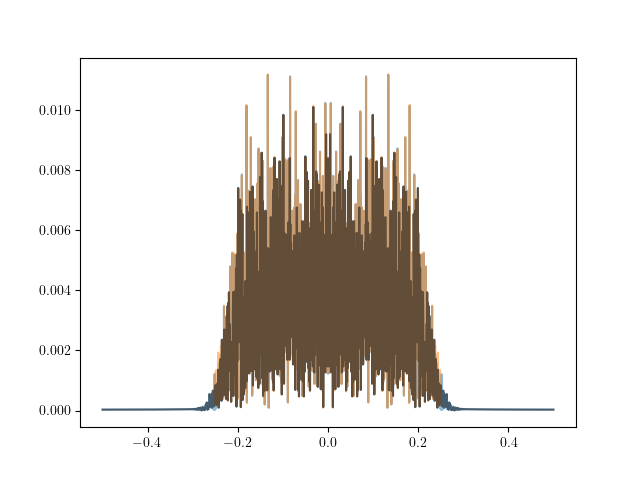

In [13]:
%matplotlib notebook
sig = np.random.rand(2**12)-0.5
fir_firwin = scipy.signal.firwin(60, 0.5, 1)
sig = scipy.signal.lfilter(fir_firwin, [1.], sig)
sig = scipy.signal.lfilter(fir_firwin, [1.], sig)
sig = scipy.signal.lfilter(fir_firwin, [1.], sig)
fig = np.fft.fft(sig)/2**12
freq = np.fft.fftfreq(2**12,1)
fig2 = np.fft.fft(sig[:2**11])+np.fft.fft(sig[2**11:])
fig2/=2**12
freq2 = np.fft.fftfreq(2**11,1)
sig_dec = sig[::2]
fig_dec = np.fft.fft(sig_dec)/2**11
freq_dec = np.fft.fftfreq(sig_dec.size, 2)
plt.figure()
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(np.abs(fig)), alpha=.5)
plt.plot(np.fft.fftshift(freq_dec), np.fft.fftshift(np.abs(fig_dec)), alpha=.5)
plt.plot(np.fft.fftshift(freq2), np.fft.fftshift(np.abs(fig2)), alpha=.5, color='black')
plt.show()

<IPython.core.display.Javascript object>


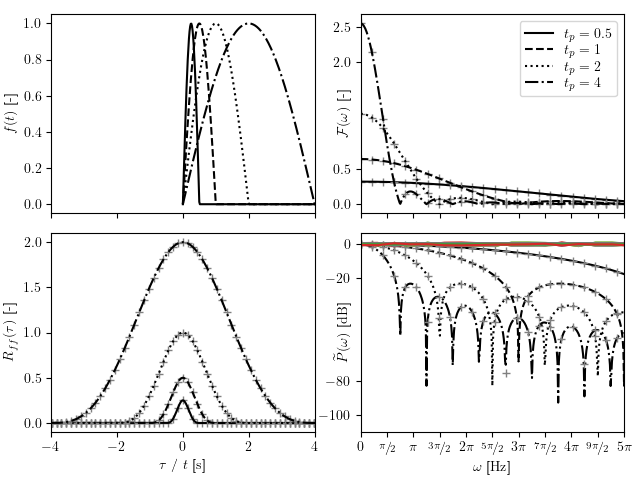

In [30]:
plt.rc('text',usetex=True)
omega = np.linspace(0,20,500)
fig,axes=plt.subplots(2,2, sharex='col')
ax1,ax2,ax3,ax4 = axes.flat

t= np.linspace(0,3*np.pi,512)
deltat=t[1]-t[0]
tau= np.linspace(-1.5*np.pi-deltat/2,1.5*np.pi-deltat/2,512)

with matplotlib.rc_context(rc=print_context_dict):
    for ls_,tp in [('solid',.5), ('dashed',1), ('dotted',2), ('dashdot',4)]:

        pulse=np.sin(np.pi/tp*t)
        pulse[t>tp]=0

        ax1.plot(t, pulse, ls=ls_, color='black', label=f'$t_p={tp}$')

        Rff = tp/2/np.pi*np.abs(np.sin(np.pi*tau/tp))+0.5*(tp-np.abs(tau))*np.cos(np.pi*tau/tp)
        Rff[tau>tp]=0
        Rff[tau<-tp]=0

        Rffn = np.correlate(pulse, pulse, 'same')*deltat

        ax3.plot(tau[::8], Rffn[::8], marker='+', color='grey',ls='none')
        ax3.plot(tau, Rff, ls=ls_, color='black', label=f'$t_p={tp}$')

        fft=np.fft.rfft(pulse)
        fft*=deltat
        fftfreq=np.fft.rfftfreq(pulse.shape[0],deltat)
        fftomega=fftfreq*2*np.pi

        F=2*np.pi/tp*np.cos(tp*omega/2)/(np.pi**2/tp**2-omega**2)*np.exp(-1j*tp*omega/2)
        mag=np.abs(F)
        phase=np.angle(F)
        phase[phase<=0]+=2*np.pi

        ax2.plot(fftomega, np.abs(fft), marker='+', color='grey',ls='none')
        ax2.plot(omega, mag, ls=ls_, color='black', label=f'$t_p={tp}$')

        psd=(2*np.pi/tp*np.cos(tp*omega/2)/(np.pi**2/tp**2-omega**2))**2/((2*np.pi/tp/(np.pi**2/tp**2)))**2
        psd=10*np.log10(psd)

        psdn=fft*np.conj(fft)
        psdn=np.abs(fft)**2
        psdn /=psdn[0]
        psdn=10*np.log10(psdn)

        ax4.plot(omega, psd, ls=ls_, color='black', label=f'$t_p={tp}$')
        #ax4.psd(pulse, Fs=1/(t[1]-t[0]),window=matplotlib.mlab.window_none,sides="onesided", label=f'$t_p={tp}$', NFFT=1024)
        ax4.plot(fftomega, psdn, marker='+', color='grey',ls='none')

    ax3.set_xlim((-1*tp,1*tp))
    ax4.set_xlim((0,5*np.pi))
    ax2.legend()

    ax1.set_ylabel('$f(t)$  [-]')

    ax2.set_yticks([0,0.5,2.0,2.5])
    ax2.set_ylabel('$\mathcal{F}(\omega)$  [-]', labelpad=-13)

    ax3.set_xlabel('$\\tau$ / $t$ [\\si{\\second}]')
    ax3.set_ylabel('$R_{ff}(\\tau)$  [-]')

    ax4.set_xlabel('$\\omega$ [\\si{\\hertz}]')
    ax4.set_yticks([-100,-80,-20,0])
    ax4.set_ylabel('$\\widetilde{P}(\omega)$  [\si{\decibel}]', labelpad=-23)

    ax4.xaxis.set_major_locator(plt.MultipleLocator(0.5*np.pi))
    ax4.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    #ax3.xaxis.set_major_locator(plt.MultipleLocator(tp/3))
    #ax3.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=3,number=tp,latex='t_p')))

    fig.subplots_adjust(top=0.970, bottom=0.10, left=0.08, right=0.975, hspace=0.1, wspace=0.175)

    fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine.pdf')
    fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/spectral_density_half_sine.png')

    plt.show()

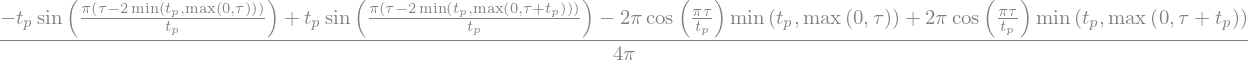

In [15]:
tp = symbols('t_p',positive=True)
t,tau = symbols('t \\tau')
f1=Piecewise((0,(t<0)),(0,(t<tau)),(sin(pi/tp*t),(t<tp+tau)),(0,True))
f2=Piecewise((0,(t<0)),(0,(t<tau)),(sin(pi/tp*(t-tau)),(t<tp+tau)),(0,True))
#f=sin(pi/tp*t)
ff=f1*f2
Rff=integrate(ff,(t,-tp,tp))
Rffs = simplify(Rff)
display(Rffs)

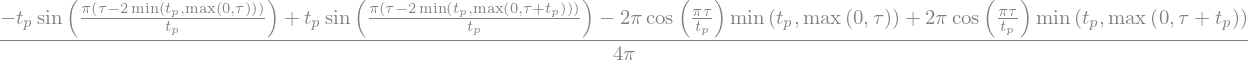

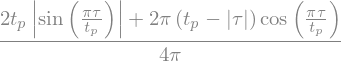

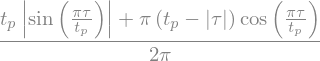

<IPython.core.display.Javascript object>


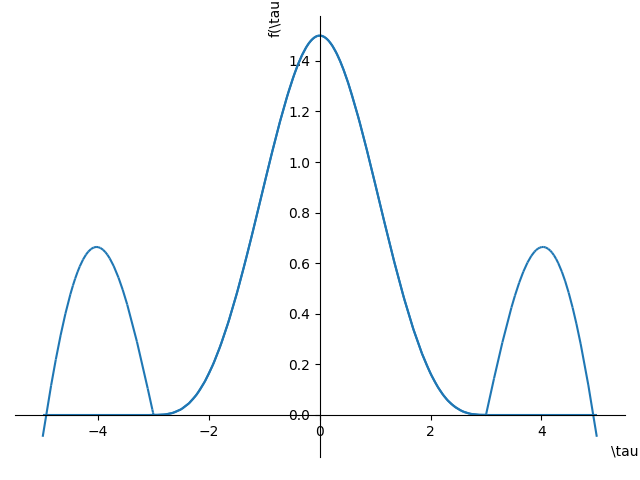

In [16]:
plt.rc('text',usetex=False)
display(Rffs)

Rffnew = (tp*(abs(sin(pi*tau/tp))+sin(pi*(abs(tau)-2*tp)/tp))+2*pi*cos(pi*tau/tp)*(tp-abs(tau)))/(4*pi)
Rffnew = (tp*(2*abs(sin(pi*tau/tp)))+2*pi*cos(pi*tau/tp)*(tp-abs(tau)))/(4*pi)
display(Rffnew)
display(simplify(Rffnew))
p=plot(simplify(Rff.subs(tp,3)),(tau,-5,5), show=False)
p.append(*plot(simplify(Rffnew.subs(tp,3)),(tau,-5,5),show=False))
#p.append(*plot(simplify(((2*pi*cos(pi*tau/tp)*(tp-abs(tau)))/(4*pi)).subs(tp,3)),(tau,-5,5),show=False))
#p.append(*plot(simplify((tp*(abs(sin(pi*tau/tp))+sin(pi*(abs(tau)-2*tp)/tp))/(4*pi)).subs(tp,3)),(tau,-5,5),show=False))
p.show()
#plot(f1.subs(tp,2).subs(tau,-0.1),(t,-2,2))
#plot(f2.subs(tp,2).subs(tau,-0.1),(t,-2,2))

32768
Power time-domain: 1.0665888287524732


<IPython.core.display.Javascript object>


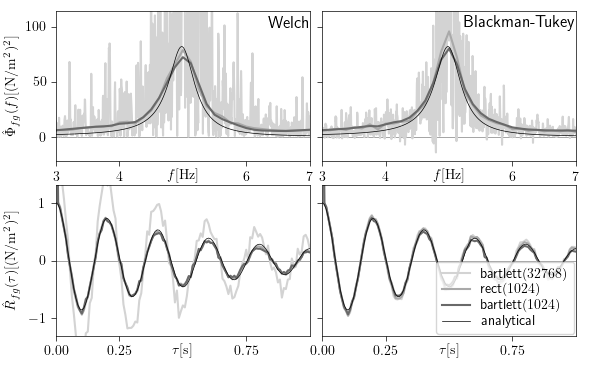

$\text{bartlett}(32768)$
Power time-domain: 62.73170773623306
SNR=-6.168020348456752 dB
Welch:
PSD: 10.251416637077012
0-lag corr * n_lines: 10.251685088925921
16385 16385
Blackman-Tukey:
PSD: 5.177968800630125
0-lag corr * n_lines: 5.1779826917929075
16385 16385
$\text{rect}(1024)$
Power time-domain: 120.93535824543761
SNR=-6.211099533356914 dB
Welch:
PSD: 5.292286247764604
0-lag corr * n_lines: 5.29917496885081
513 513
Blackman-Tukey:
PSD: 5.218266816526341
0-lag corr * n_lines: 5.222209647913812
513 513
$\text{bartlett}(1024)$
Power time-domain: 120.93535824543761
SNR=-6.211099533356914 dB
Welch:
PSD: 5.258215293093535
0-lag corr * n_lines: 5.264676948087837
513 513
Blackman-Tukey:
PSD: 5.214157429706502
0-lag corr * n_lines: 5.217104848648989
513 513
Theoretic powers
PSD: 1.0
0-lag corr: 1.0


In [1991]:
%matplotlib notebook
import scipy.signal

do_plot = True

# signal parameters
N=2**15
fs = 128
dt = 1/fs

omegas = np.fft.fftfreq(N, 1 / fs) * 2 * np.pi
t = np.linspace(0, N / fs, N, False)

# spectral estimation parameters
nperseg_fac = 1
window = np.bartlett
n_lines = N // nperseg_fac
print(n_lines)

tau = np.linspace(0, (n_lines //2 + 1) / fs, n_lines // 2 + 1, False)
omegasr = np.fft.rfftfreq(n_lines, 1 / fs) * 2 * np.pi


#generate sdof system
zeta = 0.05
omega = 5*2*np.pi*np.sqrt(1-zeta**2) # damped f = 5 Hz
# omega = 6.46524269*2*np.pi
m = 1
k = omega**2*m
#c = zeta*2*sqrt(m*k)
H = -omega**2 / (k * (1 + 2j * zeta * omegas / omega - (omegas / omega)**2))

# generate ambient input forces
f_scale = 10
phase = np.random.uniform(-np.pi, np.pi, (N // 2 + 1,))
ampli = np.exp(1j * np.concatenate((phase[:N // 2 + N % 2], -1 * np.flip(phase[1:]))))
Pomega = f_scale * np.ones(N, dtype=complex) * ampli

# make the ifft real-valued
Pomega.imag[0] = 0
Pomega[N // 2 + N % 2] = np.abs(Pomega[N // 2 + N % 2])
H.imag[0] = 0
H[N // 2 + N % 2] = np.abs(H[N // 2 + N % 2])

# generate the  ambient response signal
y_ = np.fft.ifft(H * Pomega) #

# discard machine-precision zero imaginary parts
if np.all(np.isclose(y_.imag,0)): y_ = y_.real
else: raise RuntimeError(str(np.where(~np.isclose(y_.imag,0))))

# DN=2**14
# y_=y_[DN:-DN]
# N=2**15
# add noise
noise = np.random.normal(0,0.125,N) # noise adds zero energy due to zero mean?
    
    


if False:
    plt.figure()
    plt.plot(y_)
    plt.show()
    
if False:
    plt.figure()
    plt.plot(np.fft.fftshift(omegas)/2/np.pi, np.fft.fftshift(np.abs(np.fft.fft(y))))
    plt.plot(np.fft.fftshift(omegas)/2/np.pi, np.fft.fftshift(np.abs(H) * np.mean(np.abs(Pomega))))
    plt.show()

power = np.sum(y[:-(n_lines // 2)]**2)
print(f'Power time-domain: {power}')

def analytical():
    # compute analytical spectrum and correlation functions with correct scaling
    # psd = np.abs(H)**2*f_scale**2
    psd = omega**4/ (k**2 * (1 + (4 * zeta**2 - 2) * (omegas / omega)**2 + (omegas / omega)**4)) * f_scale**2
    # make it unity power
    psd /= np.mean(psd)
    # analytical solution for convolution difficult, use numerical inverse of analytical PSD
    corr = np.fft.ifft(psd)
    # discard machine-precision zero imaginary parts
    if np.all(np.isclose(corr.imag,0)): corr = corr.real
    else: raise RuntimeError()

    if do_plot:
        ax1.plot(np.fft.fftshift(omegas)/2/np.pi, np.fft.fftshift(psd), label='analytic', color='black', lw=0.5)
        ax3.plot(t, corr, label='analytic', color='black', lw=0.5)
        ax2.plot(np.fft.fftshift(omegas)/2/np.pi, np.fft.fftshift(psd), label='analytic', color='black', lw=0.5)
        handles.append(ax4.plot(t, corr, label='analytic', color='black', lw=0.5)[0])

    print(f'Theoretic powers')
    print(f'PSD: {np.mean(psd)}')
    print(f'0-lag corr: {corr[0]}')

def spec_wl():    
    # compute spectrum according to welch, with automatic application of a window and scaling
    # specrum scaling compensates windowing by dividing by window(n_lines).sum()**2
    # density scaling divides by fs * window(n_lines)**2.sum()
    win = window(n_lines//2+1)
    win = window(n_lines//2+1)
    if True:
        freq_wl, spec_wl = scipy.signal.welch(y, fs, 
                                          window=win,
                                          nfft=n_lines,
                                          noverlap = 0,
                                          detrend = False,
                                          return_onesided=True,
                                          scaling='density')
        # reverse 1/Hz of scaling="density"
        spec_wl *= fs
    else:
        # manual Welch 
        freq_wl = np.fft.rfftfreq(n_lines, 1/fs)
        
        P_win = np.sum(win**2)
        spec_wl = np.zeros((n_lines//2+1,nperseg_fac))
        for s in range(nperseg_fac):
            print(s, (s+1)*n_lines)
            this_y = y[s*n_lines:(s+1)*n_lines]
            this_Y = np.fft.rfft(this_y*win)
            spec_wl[:,s] = (this_Y*np.conj(this_Y)/P_win).real
        
        spec_wl = np.mean(spec_wl, axis=1)
    # compensate averaging over segments (for power equivalence segments should be summed up)
    spec_wl *= nperseg_fac
    # compensate onesided
    spec_wl /= 2
    # compensate energy loss through shorter segments
    spec_wl *= n_lines
    # transform correlation function
    corr_wl = np.fft.irfft(spec_wl)[:n_lines // 2 + 1].real
    # divide by n_lines [equivalence of r(0) and Var(y)]
    corr_wl /= n_lines
    if do_plot:
    #     ax1.plot(np.fft.fftshift(omegas_wl)/2/np.pi, np.fft.fftshift(spec_wl), alpha=.5, label='welch')
        ax1.plot(freq_wl, spec_wl, label=label, color=color)
        # plot normalized correlation functions
        ax3.plot(tau, corr_wl*n_lines,  label=label, color=color)


    print(f'Welch:')
    print(f'PSD: {np.mean(spec_wl)}')
    print(f'0-lag corr * n_lines: {corr_wl[0]*n_lines}')
    print(len(spec_wl),len(corr_wl))
    
def spec_bt():
    # compute correlation function according to blackman-tukey and transform spectrum

    # naive implementation
    # corr_bt = np.fft.fftshift(np.correlate(y, y, 'same') * window(N))
    # spec_bt = np.fft.fft(corr_bt)

    # compute direct correlation, only positive lags with length: n_lines // 2 + 1
    corr_btr = np.correlate(y, y[:-(n_lines // 2)], 'valid') 
    # standard unbiased estimator
    corr_btr /= n_lines-tau
    # compute the half-window
    win = window(n_lines)
    win2 = np.convolve(win, win, 'same')
    win2 = win[n_lines // 2 - 1:]
    corr_btr *= win2
    
    # compute the spectrum by the FFT (inverse FFT is equivalent if input and output are real)
    # which is not the case for Cross-PSDs
    # anyways, we have a one-sided correlation sequence
    # R_fg(-tau) = R_gf(tau), where R_gf= conj(R_fg) for real input
    spec_btr = np.fft.irfft(corr_btr)
    # reverse backward scaling (newer numpy versions allow norm='forward' which obsolotes the below)
    spec_btr *= n_lines
    # compensate power loss through shorter segments
    spec_btr *= n_lines
    # restrict the spectrum to positive frequencies
    spec_btr = spec_btr[:n_lines // 2 + 1]
    # density scaling as in Welch not needed here, because, 
    # we are equating corr[0] with signal power and not the correlation sequence

    # verification with mirrored correlations and rfft
    # corr_btr2 = np.concatenate([corr_btr[:-1],np.flip(corr_btr)[:-1]])
    # spec_btr2 = np.fft.rfft(corr_btr2)

    if do_plot:
        ax2.plot(omegasr/2/np.pi, spec_btr,  label=label, color=color)
        # plot normalized correlation functions
        handles.append(ax4.plot(tau, corr_btr*n_lines,  label=label, color=color)[0])

    print(f'Blackman-Tukey:')
    print(f'PSD: {np.mean(spec_btr)}')
    print(f'0-lag corr * n_lines: {corr_btr[0] * n_lines}')
    print(len(spec_btr),len(corr_btr))
    
    
with matplotlib.rc_context(rc=print_context_dict):
    if do_plot:
        fig1, axes = plt.subplots(2,2, sharex='row', sharey='row')
        ax1,ax2,ax3,ax4 = axes.flat
        for ax in axes.flat:
            ax.axhline(0, color='gray', linewidth=0.5)
        #fig2, ax2 = plt.subplots(1,1)
    handles=[]
    labels = []
    for nperseg_fac, window, color in list(zip((1,32,32),(np.bartlett, np.ones,np.bartlett),['lightgrey','darkgrey','dimgrey'])):

        # spectral estimation parameters
        n_lines = N // nperseg_fac
#         print(n_lines)
        if window == np.ones:
            label=f'$\\text{{rect}}({n_lines})$'
        else:
            label=f'$\\text{{{window.__name__}}}({n_lines})$'
        print(label)
        labels.append(label)
        power = np.sum(y_[:-(n_lines // 2)]**2)
        print(f'Power time-domain: {power}')
        power_noise = np.sum(noise[:-(n_lines // 2)]**2)
        print(f'SNR={10*np.log10(power/power_noise)} dB')
        y = np.copy(y_+noise)/np.sqrt(power)
        tau = np.linspace(0, (n_lines // 2 +1 )/ fs, n_lines // 2 + 1, False)
        omegasr = np.fft.rfftfreq(n_lines, 1 / fs) * 2 * np.pi
        spec_wl()
        spec_bt()

    analytical()
    labels.append('analytical')
    #ax1.legend()
    #ax2.legend()
    #ax3.legend()
    #ax4.legend()
    leg=fig1.legend(handles,labels, loc=(0.739,0.085))
    
    for ax in ax1,ax2:
        ax.set_xticks([3,4,6,7])
        ax.set_xlabel("$f [\\si{{\hertz}}]$", labelpad=-10)
    ax1.set_ylabel('$\hat{\\Phi}_{fg}(f) [(\\si{{\\newton\\per\\metre\\squared}})^2]$')
    ax1.set_title("Welch", loc='right', y=0.83)
    ax2.set_title("Blackman-Tukey", loc='right', y=0.83)
    for ax in ax3,ax4:
        ax.set_xticks([0.0,0.25,0.75])
        ax.set_xlabel("$\\tau [\\si{{\second}}]$", labelpad=-10)
    ax3.set_ylabel('$\hat{R}_{fg}(\\tau) [(\\si{{\\newton\\per\\metre\\squared}})^2]$')

    ax1.set_xlim((3,7))
    ax1.set_ylim((-5,60))
    ax3.set_xlim((0,1))
    ax3.set_ylim((-1.3,1.3))
    fig1.subplots_adjust(top=0.970, bottom=0.08, left=0.095, right=0.975, hspace=0.16, wspace=0.05)
    fig1.align_ylabels()
#     fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/example_psd_estimators2.pdf')
#     fig1.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/example_psd_estimators2.png')

    plt.show()

In [1169]:
4//2


<IPython.core.display.Javascript object>


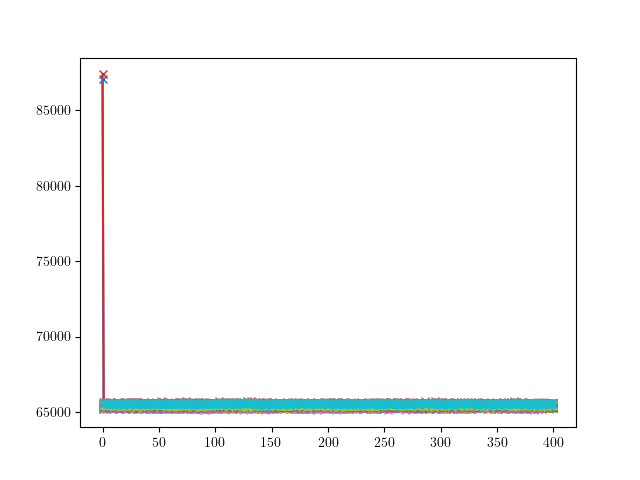

In [417]:
plt.figure()
N=65536*4
c1=10
c2=2
y = np.random.random((N,c))
tau_max = 400

def f1(y,tau_max):
    # slightly more efficient than the below with few ref channels
    c1 = y.shape[1]
    c2 = 2
    corr = np.empty((tau_max+1,c1,c2))
    for j in range(c1):
        for k in range(c2):
            corr[:,j,k] = np.correlate(y[:,j], y[:-tau_max,k], 'valid')
    return corr

def f2(y, tau_max):
    # slightly more efficient than the above with many ref channels
    N,c1 = y.shape
    c2 = 2
    corr2=np.zeros((tau_max+1,c1,c2))
    for i in range(tau_max+1):
        corr2[i,:,:] = y[:-tau_max,:].T.dot(y[i:N-tau_max + i,:c2])
    return corr2

corr = f1(y, tau_max)
for j in range(c1):
    for k in range(c2):
        plt.plot(corr[:,j,k])
#ener = np.sum(y[:-tau_max]**2, axis=0)
#zerolag = np.where(np.isclose(corr,ener))
#plt.axhline(ener)
#plt.axvline(zerolag)

#corr2[i+1:] = np.flip(corr2[1:i])
corr2 = f2(y,tau_max)
for j in range(c1):
    for k in range(c2):
        plt.plot(corr2[:,j,k], ls='none', marker='x')

plt.show()

In [418]:
runtimes1 = np.zeros((4,5,6))
runtimes2 = np.zeros((4,5,6))
for cN,N in enumerate((6,10,14,18)):
    N=2**N
    for cc,c in enumerate((2,6,10,14,18)):
        for ctau,tau_max in enumerate((20,60,100,200,400,800)):
            if tau_max > N: continue
            y = np.random.random((N,c))
            print(f'\n N={N}, c={c}, tau_max={tau_max}')
            runtimes1[cN,cc,ctau] = timeit.timeit('f1(y,tau_max)', globals=globals(), number=10)
            runtimes2[cN,cc,ctau] = timeit.timeit('f2(y,tau_max)', globals=globals(), number=10)


 N=64, c=2, tau_max=20

 N=64, c=2, tau_max=60

 N=64, c=6, tau_max=20

 N=64, c=6, tau_max=60

 N=64, c=10, tau_max=20

 N=64, c=10, tau_max=60

 N=64, c=14, tau_max=20

 N=64, c=14, tau_max=60

 N=64, c=18, tau_max=20

 N=64, c=18, tau_max=60

 N=1024, c=2, tau_max=20

 N=1024, c=2, tau_max=60

 N=1024, c=2, tau_max=100

 N=1024, c=2, tau_max=200

 N=1024, c=2, tau_max=400

 N=1024, c=2, tau_max=800

 N=1024, c=6, tau_max=20

 N=1024, c=6, tau_max=60

 N=1024, c=6, tau_max=100

 N=1024, c=6, tau_max=200

 N=1024, c=6, tau_max=400

 N=1024, c=6, tau_max=800

 N=1024, c=10, tau_max=20

 N=1024, c=10, tau_max=60

 N=1024, c=10, tau_max=100

 N=1024, c=10, tau_max=200

 N=1024, c=10, tau_max=400

 N=1024, c=10, tau_max=800

 N=1024, c=14, tau_max=20

 N=1024, c=14, tau_max=60

 N=1024, c=14, tau_max=100

 N=1024, c=14, tau_max=200

 N=1024, c=14, tau_max=400

 N=1024, c=14, tau_max=800

 N=1024, c=18, tau_max=20

 N=1024, c=18, tau_max=60

 N=1024, c=18, tau_max=100

 N=1024, c=18, tau_

In [337]:
def f(y, tau_max):
    corr2=np.zeros(tau_max+1)
    for i in range(tau_max+1):
        corr2[i] = y[:-tau_max].dot(y[i:N-tau_max + i])
    return corr2

import timeit
print(timeit.timeit('np.correlate(y,y[:-400],"valid")', globals=globals(), number=10))
print(timeit.timeit('f(y,400)', globals=globals(), number=10))

0.096406594151631
0.11045089899562299


-188.1707177032426 53.71458118589177


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


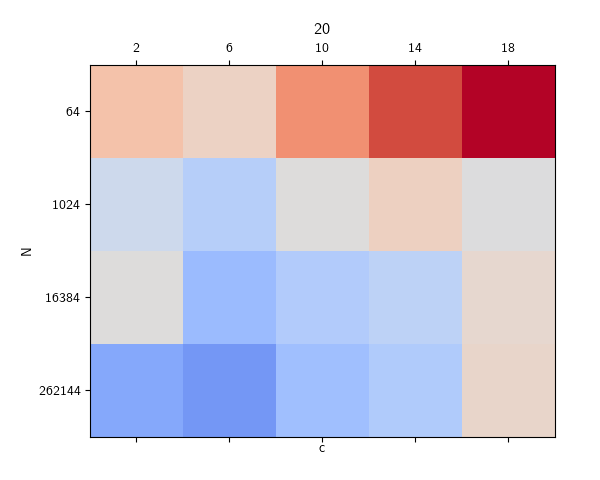

<IPython.core.display.Javascript object>


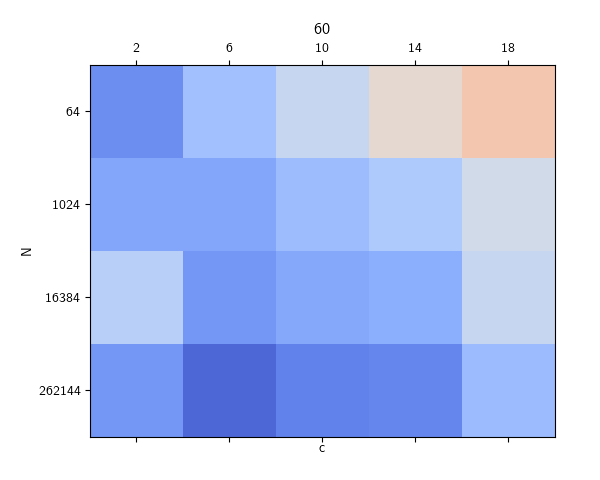

<IPython.core.display.Javascript object>


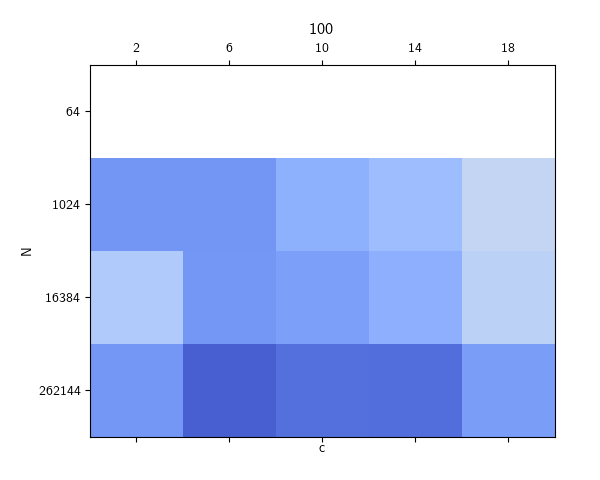

<IPython.core.display.Javascript object>


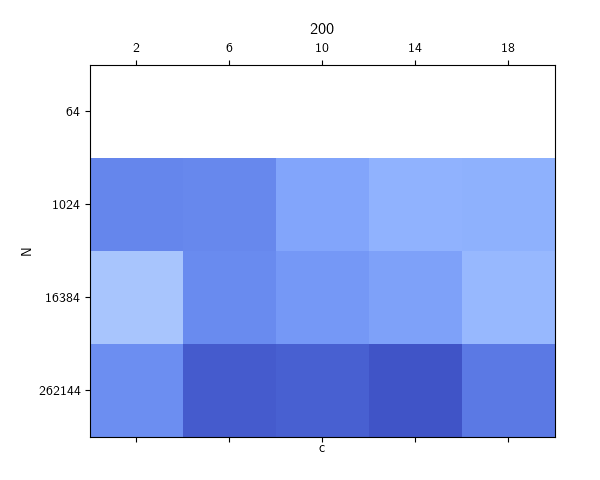

<IPython.core.display.Javascript object>


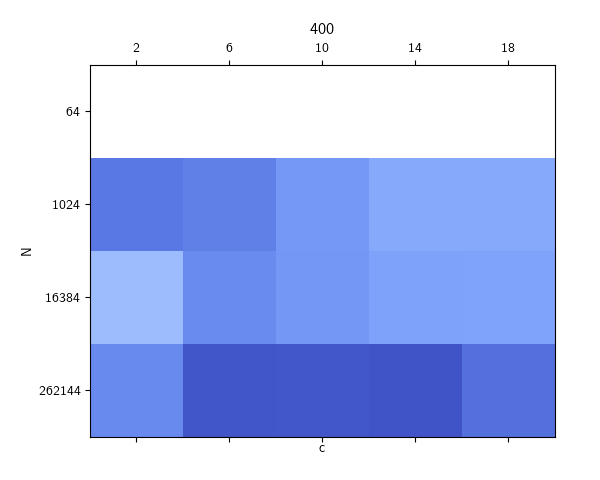

<IPython.core.display.Javascript object>


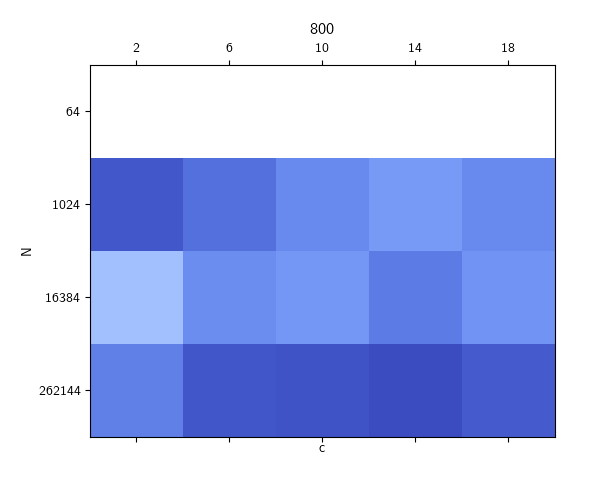

In [419]:

delta = 100*2*(runtimes1-runtimes2)/(runtimes1+runtimes2)
print(np.nanmin(delta),np.nanmax(delta))
for ctau,tau_max in enumerate((20,60,100,200,400,800)):
    plt.matshow(delta[:,:,ctau], cmap='coolwarm', vmin=np.nanmin(delta),vmax=np.nanmax(delta))
    plt.ylabel('N')
    plt.yticks([0,1,2,3],[f'{2**6}',f'{2**10}',f'{2**14}',f'{2**18}'])
    plt.xlabel('c')
    plt.xticks([0,1,2,3,4],['2','6','10','14','18'])
    plt.title(f'{tau_max}')

<IPython.core.display.Javascript object>


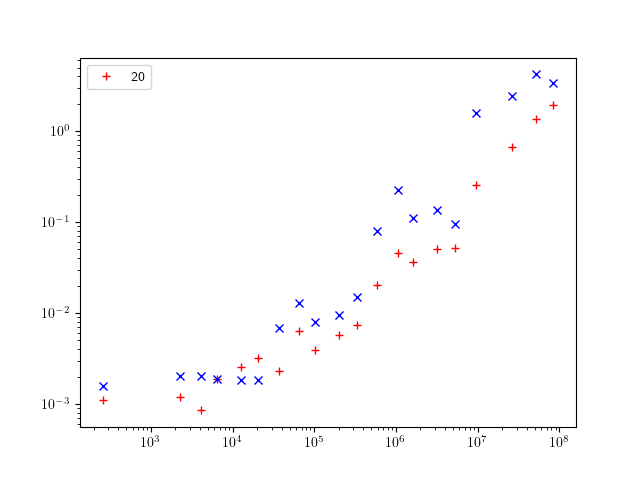

<IPython.core.display.Javascript object>


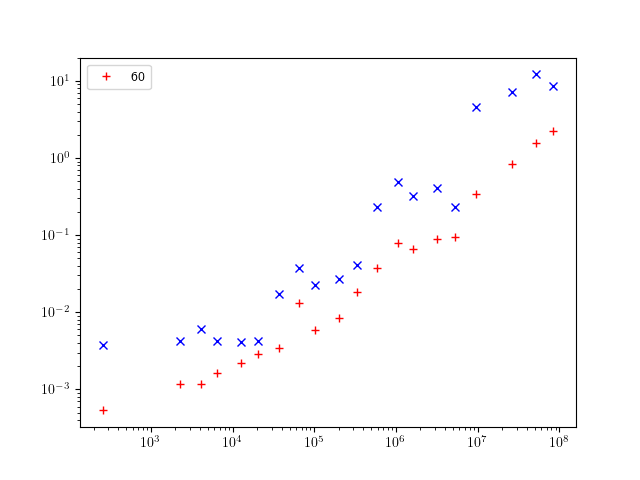

<IPython.core.display.Javascript object>


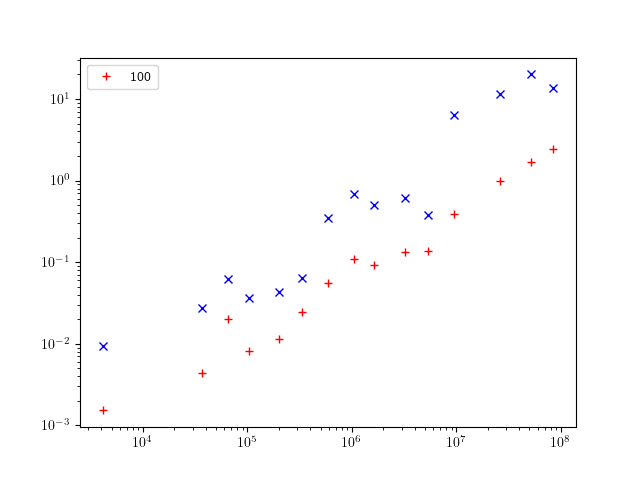

<IPython.core.display.Javascript object>


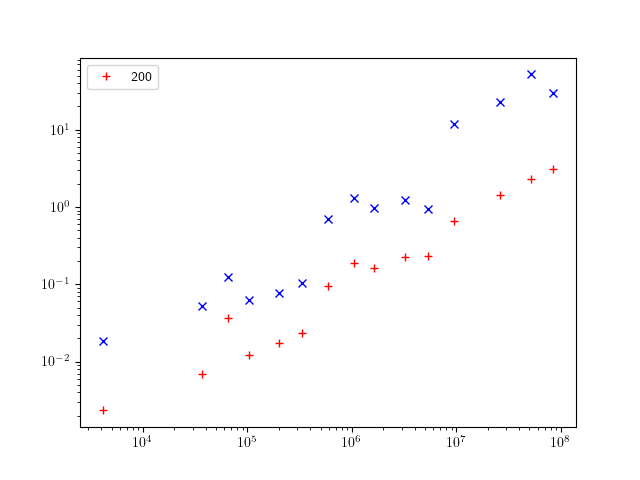

<IPython.core.display.Javascript object>


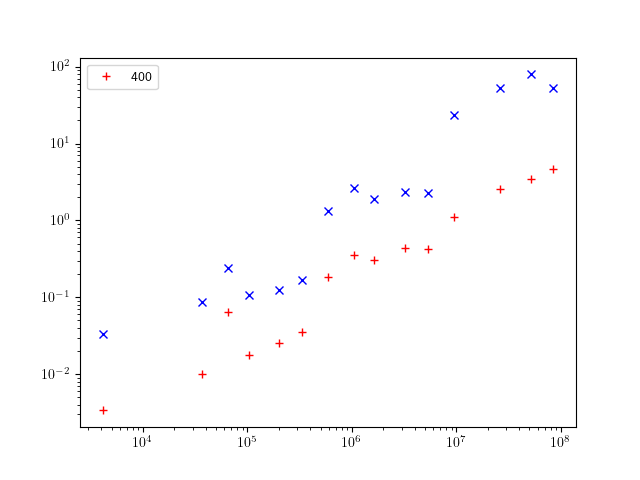

<IPython.core.display.Javascript object>


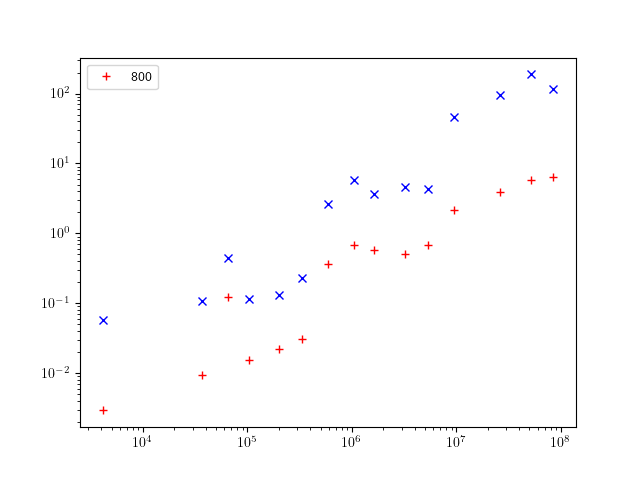

In [420]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for ctau,tau_max in enumerate((20,60,100,200,400,800)):
    plt.figure()
    color = colors[ctau]
    label = str(tau_max)
    for cN,N in enumerate((6,10,14,18)):
        N=2**N
        for cc,c in enumerate((2,6,10,14,18)):
            if not runtimes1[cN,cc,ctau]: continue
            plt.plot([N*c**2],[runtimes1[cN,cc,ctau]], ls='none', marker='+', color='red', label=label)
            plt.plot([N*c**2],[runtimes2[cN,cc,ctau]], ls='none', marker='x', color='blue')
            label=None
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
plt.show()

<IPython.core.display.Javascript object>


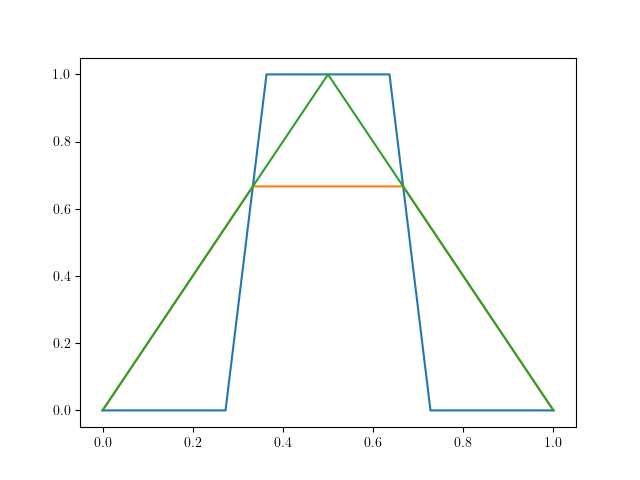

9


In [1309]:
n_lines = 3
n_lags = n_lines // 2 + 1
plt.figure()
win = np.ones(2*n_lags)
winpad = np.concatenate((np.zeros(2*n_lags),win,np.zeros(2*n_lags)))
plt.plot(np.linspace(0,1,len(winpad)), winpad)

plt.plot(np.linspace(0,1,2*n_lags), np.bartlett(2*n_lags))
winf = 1 - np.fft.ifft(np.fft.fft(win)**2) / (2*n_lags)
#plt.plot(np.linspace(0,1,len(winf)), winf)
winc = np.convolve(winpad, win, 'valid') / (2*n_lags)
print(len(winc))
plt.plot(np.linspace(0,1,len(winc)), winc)


#### Lag Window Computation ####

In [2]:
nlines = 32
fs=128

# lag indices for correlation function
k_dir = np.linspace(-nlines,nlines,2*nlines, False)

win_func = scipy.signal.windows.bartlett
win_func = np.bartlett
# Generate Full-Length Window
win = win_func(nlines+1)[:nlines]#, sym=2*nlines%2)
# Zero-Pad both sides (= zero pad once and circular convolution) 
# to allow the window to "slide along" the correct number of lags in np.convolve = 3 * nlines - 1
# here first (!) zero pad is nlines-1 because it is convolve
win_pad = np.concatenate((np.zeros(nlines-1),win,np.zeros(nlines)))
# Convolve zero-padded and unpadded window
# resulting shape: M - N + 1 = (3 * nlines - 1) - (nlines) + 1 = 2 * nlines = 2*nlines
corr_win=np.convolve(win_pad, win, 'valid')
corr_win/=nlines#-np.abs(k_dir)
# normalize lag window to 1
# corr_win /= np.max(corr_win)

# FRF of the lag-window
frf = np.fft.fftshift(np.abs(np.fft.fft(corr_win)))

# PSD of the temporal window
# zero pad window once for same frequency resolution by FFT
win_pad = np.concatenate((win, np.zeros(nlines)))# len = 2*nlines
# Normalize lag window to 1
#win_pad /= np.sqrt(np.mean(win**2))
psd_win = np.abs(np.fft.fft(win_pad))**2/(nlines)

corr_win_fft = np.fft.ifftshift(np.fft.ifft(psd_win))
#corr_win_fft /= np.max(corr_win_fft)

t = np.linspace(0, 2*nlines/fs, 2*nlines,False)
f = np.fft.fftshift(np.fft.fftfreq(2*nlines, 1/fs))

# plot lag window
plt.figure()
plt.plot(t, corr_win, label='lag window direct', marker='x')
if win_func in (np.ones,scipy.signal.windows.boxcar):
    # generate Bartlett window for validation considering symmetry to make it a DFT periodic window
    # https://en.wikipedia.org/wiki/Window_function#Symmetry
    bartl = scipy.signal.windows.bartlett(2*nlines, sym=2*nlines%2)
    plt.plot(t, bartl, label='bartlett')
plt.plot(t, corr_win_fft, label='lag window spectral', marker='x')
plt.legend()

plt.figure()
if win_func in (np.ones,scipy.signal.windows.boxcar):
    plt.semilogy(f, np.fft.fftshift(np.abs(np.fft.fft(bartl))))

plt.semilogy(f, frf, label='frf lag window')
plt.semilogy(f, np.fft.fftshift(psd_win), label='psd temporal window')
plt.legend()


# generate full length signal
sig_ = 0.5*np.random.normal(size=2*nlines)+np.sin(np.linspace(0,17*np.pi,2*nlines))
sig = sig_[:nlines]
# multiply by full length window
sig_win = sig*win


# zero pad once for FFT to have a correlation of length = 2*nlines
sig_pad = np.concatenate((sig_win,np.zeros(nlines)))
# compute FFT
fft_sig = np.fft.fft(sig_pad)
# compute and invert PSD to get correlation
corr_fft = np.fft.fftshift(np.fft.ifft(fft_sig*np.conj(fft_sig)))
# ensure a real sequence is obtained
if np.all(np.isclose(corr_fft.imag,0)): corr = corr.real
# divide by 2*nlines [equivalence of r(0) and Var(y)]
corr_fft /= nlines
    
# windowed correlation
# zero pad for correlation, 
# here the last (!) zero pad is nlines-1 because it is correlate
sig_pad = np.concatenate((np.zeros(nlines),sig_win,np.zeros(nlines-1)))
# compute convolution with length = 2*nlines
corr_dir_win = np.correlate(sig_pad, sig_win, 'valid')
# unbiased estimator (windowed, no need to reverse rectangular window)
corr_dir_win /= nlines

# unwindowed correlation
# zero pad for correlation
corr_dir = np.empty(nlines+1)
for lag in range(nlines+1):
    corr_dir[lag] = sig[lag:nlines].dot(sig[:nlines-lag])
#corr_dir = np.correlate(sig_pad, sig, 'valid')
corr_dir = np.concatenate((np.flip(corr_dir)[:nlines], corr_dir[:nlines]))
# unbiased estimator = reverse rectangular window
corr_dir /= nlines-np.abs(k_dir)

sig_pad = np.concatenate((np.zeros(nlines),sig,np.zeros(nlines-1)))
corr_dir2 = np.correlate(sig_pad, sig, 'valid')
# unbiased estimator = reverse rectangular window
corr_dir2 /= nlines-np.abs(k_dir)

plt.figure()

plt.plot(k_dir, corr_fft, label='ifft(fft(sig win)**2)', ls='solid')
plt.plot(k_dir, corr_dir*corr_win, label='win corr(sig)', ls='dashed')
plt.plot(k_dir, corr_dir2*corr_win, label='win corrfull(sig)', ls='dotted')
# plt.plot(k_dir, corr_dir, label='win corr(sig)')
plt.plot(k_dir, corr_dir_win, label='corr(sig win)', ls='dashdot')
# scale temporal window to signal power
#plt.plot(k_fft, win*np.mean(sig_win**2), label='temporal window')
plt.plot(k_dir, win_func(2*nlines+1)[:2*nlines]*np.mean(sig_win**2), label='temporal window')
# scale lag window to signal power
plt.plot(k_dir, corr_win*np.mean(sig**2), label='lag window')
plt.axvline(0)
plt.legend()
plt.show()

print(np.mean(sig**2))
print(np.mean(sig_win**2))
print(np.mean(win**2))

/usr/wrk/people9/sima9999/my-python/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


NameError: name 'corr' is not defined

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/usr/scratch4/sima9999/.cache/matplotlib/tex.cache/0acfe93d73d4a756e83488b4b20
b3b4c.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)

! LaTeX Error: File `siunitx.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.12  \usepackage
                 {xfrac}^^M
No pages of output.
Transcript written on 0acfe93d73d4a756e83488b4b20b3b4c.log.




<Figure size 432x288 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/usr/scratch4/sima9999/.cache/matplotlib/tex.cache/0acfe93d73d4a756e83488b4b20
b3b4c.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)

! LaTeX Error: File `siunitx.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.12  \usepackage
                 {xfrac}^^M
No pages of output.
Transcript written on 0acfe93d73d4a756e83488b4b20b3b4c.log.




<Figure size 432x288 with 1 Axes>

In [1775]:
n_lines = 5
print(np.linspace(-n_lines//2,n_lines//2,n_lines, False), n_lines//2, -n_lines//2)
print(np.linspace(-2,2,5,False))

[-3. -2. -1.  0.  1.] 2 -3
[-2.  -1.2 -0.4  0.4  1.2]
